## Yield prediction

In [16]:
import pandas as pd
df = pd.read_excel("all_merged_final.xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13807 entries, 0 to 13806
Data columns (total 42 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   istasyon_no                    13807 non-null  int64         
 1   istasyon_adi                   13807 non-null  object        
 2   yil                            13807 non-null  int64         
 3   ay                             13807 non-null  int64         
 4   hafta                          13807 non-null  int64         
 5   tarih                          13807 non-null  datetime64[ns]
 6   hafta_baslangic                13807 non-null  object        
 7   ortalama_toprak_sicakligi_5    13807 non-null  float64       
 8   ortalama_toprak_sicakligi_10   13807 non-null  float64       
 9   ortalama_toprak_sicakligi_20   13807 non-null  float64       
 10  ortalama_toprak_sicakligi_50   13807 non-null  float64       
 11  ortalama_toprak

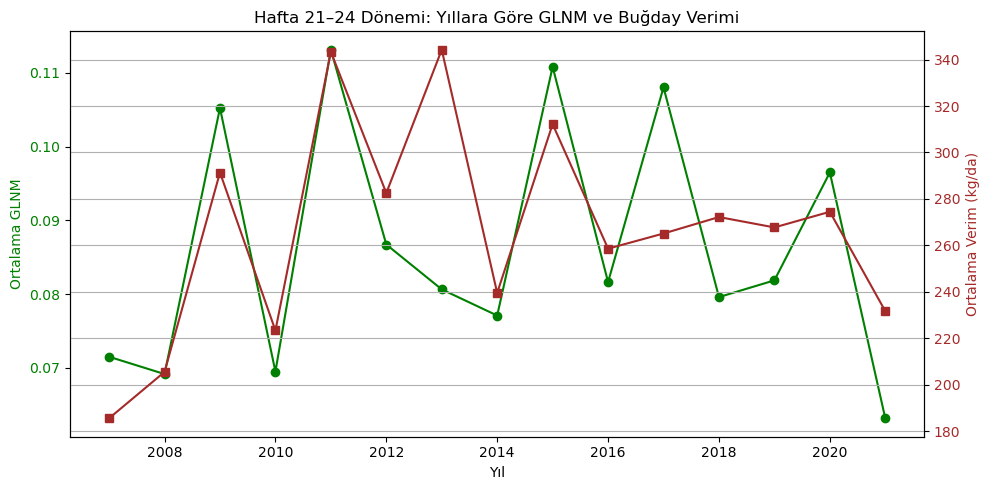

In [17]:
import matplotlib.pyplot as plt

df_21_24 = df[df["hafta"].between(21, 24)]

glnm_mean = df_21_24.groupby("yil")["GLNM"].mean()
yield_mean = df_21_24.groupby("yil")["verim"].mean()

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel("Yıl")
ax1.set_ylabel("Ortalama GLNM", color='green')
ax1.plot(glnm_mean.index, glnm_mean.values, marker='o', color='green', label='GLNM')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.set_ylabel("Ortalama Verim (kg/da)", color='brown')
ax2.plot(yield_mean.index, yield_mean.values, marker='s', color='brown', label='Verim')
ax2.tick_params(axis='y', labelcolor='brown')

plt.title("Hafta 21–24 Dönemi: Yıllara Göre GLNM ve Buğday Verimi")
fig.tight_layout()
plt.grid(True)
plt.show()


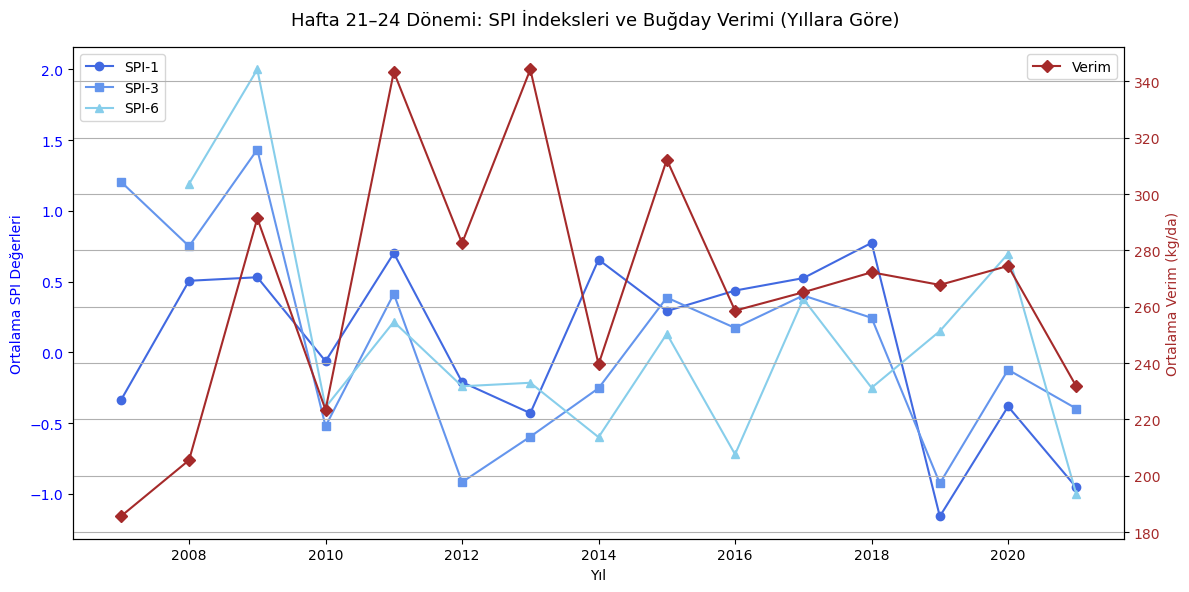

In [18]:
# Hafta 21–24 verilerinde SPI indeksleri ve verim ortalamasını yıllara göre hesapla
spi1_mean = df_21_24.groupby("yil")["spi_1"].mean()
spi3_mean = df_21_24.groupby("yil")["spi_3"].mean()
spi6_mean = df_21_24.groupby("yil")["spi_6"].mean()
yield_mean = df_21_24.groupby("yil")["verim"].mean()


fig, ax1 = plt.subplots(figsize=(12, 6))


ax1.set_xlabel("Yıl")
ax1.set_ylabel("Ortalama SPI Değerleri", color='blue')
ax1.plot(spi1_mean.index, spi1_mean.values, marker='o', label='SPI-1', color='royalblue')
ax1.plot(spi3_mean.index, spi3_mean.values, marker='s', label='SPI-3', color='cornflowerblue')
ax1.plot(spi6_mean.index, spi6_mean.values, marker='^', label='SPI-6', color='skyblue')
ax1.tick_params(axis='y', labelcolor='blue')


ax2 = ax1.twinx()
ax2.set_ylabel("Ortalama Verim (kg/da)", color='brown')
ax2.plot(yield_mean.index, yield_mean.values, marker='D', label='Verim', color='brown')
ax2.tick_params(axis='y', labelcolor='brown')


fig.suptitle("Hafta 21–24 Dönemi: SPI İndeksleri ve Buğday Verimi (Yıllara Göre)", fontsize=13)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
fig.tight_layout()
plt.show()


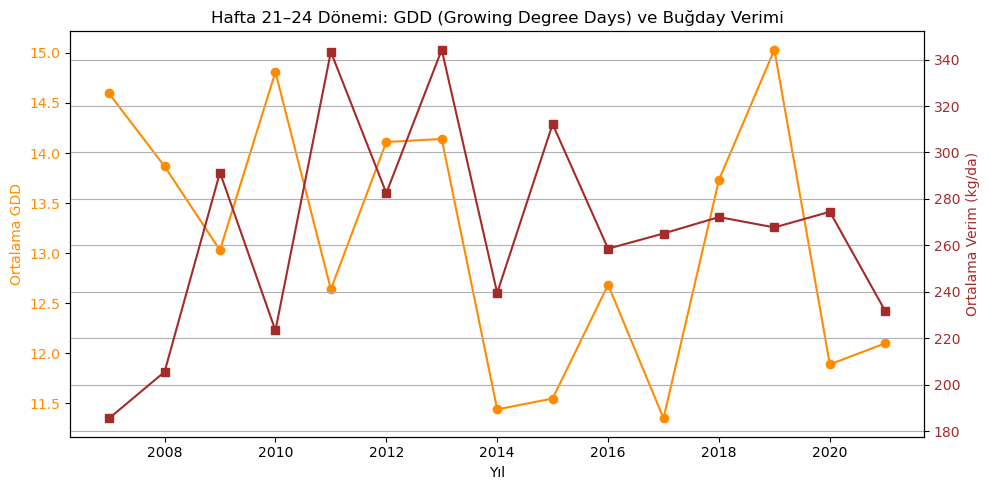

In [19]:
# Hafta 21–24 arasındaki GDD (Growing Degree Days) ve verim ortalamalarını yıllara göre hesapla
gdd_mean = df_21_24.groupby("yil")["gdd"].mean()
yield_mean = df_21_24.groupby("yil")["verim"].mean()

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel("Yıl")
ax1.set_ylabel("Ortalama GDD", color='darkorange')
ax1.plot(gdd_mean.index, gdd_mean.values, marker='o', color='darkorange', label='GDD')
ax1.tick_params(axis='y', labelcolor='darkorange')

ax2 = ax1.twinx()
ax2.set_ylabel("Ortalama Verim (kg/da)", color='brown')
ax2.plot(yield_mean.index, yield_mean.values, marker='s', color='brown', label='Verim')
ax2.tick_params(axis='y', labelcolor='brown')

plt.title("Hafta 21–24 Dönemi: GDD (Growing Degree Days) ve Buğday Verimi")
fig.tight_layout()
plt.grid(True)
plt.show()


---
## LightGBM model

In [27]:
# 1. Hafta 18–26 verisini al
critical_weeks = df[df["hafta"].between(1, 53)]

# 2. Kullanılacak sinyaller
signal_vars = [
"vhi", "ndvi", "gdd", "toplam_yagis_mm_mod", 
    "GLNM", "TCI", "VCI",                         
    "ortalama_toprak_sicakligi_5", "ortalama_toprak_sicakligi_10", "ortalama_toprak_sicakligi_20", "ortalama_toprak_sicakligi_50",
    "ortalama_toprak_nemi_20",                  
    "LST_Day_1km", "ortalama_sicaklik","spi_3", "spi_6"
]

# 3. Gerçekten var olanları al
available_signals = [col for col in signal_vars if col in critical_weeks.columns]

# 4. Trend fonksiyonu
def compute_trend(x):
    if len(x.dropna()) < 2:
        return np.nan
    return np.polyfit(range(len(x)), x.fillna(method='ffill'), 1)[0]

# 5. (yıl, istasyon) için özet istatistikleri hesapla
features_station = {}
grouped = critical_weeks.groupby(["yil", "istasyon_no"])
for var in available_signals:
    features_station[f"{var}_mean"] = grouped[var].mean()
    features_station[f"{var}_std"] = grouped[var].std()
    features_station[f"{var}_min"] = grouped[var].min()
    features_station[f"{var}_max"] = grouped[var].max()
    features_station[f"{var}_trend"] = grouped[var].apply(compute_trend)

# 6. DataFrame oluştur
X_summary_station = pd.DataFrame(features_station)

# 7. Verim değerini ekle
X_summary_station["verim"] = df.groupby(["yil", "istasyon_no"])["verim"].mean()
X_summary_station_cleaned = X_summary_station.dropna(subset=["verim"])


##########
import statsmodels.formula.api as smf

# Mixed model verisi: sadece gerekli sütunları al
mixed_data = df[["verim", "istasyon_no", "GLNM"]].dropna()

# Mixed-effects model: istasyon bazlı random intercept
md = smf.mixedlm("verim ~  GLNM", data=mixed_data, groups="istasyon_no")
mdf = md.fit(method='lbfgs', reml=False)

# Random intercept değerlerini çıkart
station_intercepts = {
    k: float(v[0]) for k, v in mdf.random_effects.items()
}

# Bu intercept'leri X_summary_station tablosuna ekle
X_summary_station_cleaned["station_intercept"] = X_summary_station_cleaned.index.get_level_values("istasyon_no").map(station_intercepts)

# NaN'leri filtrele
X_summary_station_cleaned = X_summary_station_cleaned.dropna(subset=["station_intercept"])
X_summary_station_cleaned

/var/folders/t6/8rz0bgqn1737cjj20jz1d5cm0000gn/T/ipykernel_7489/2871248107.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return np.polyfit(range(len(x)), x.fillna(method='ffill'), 1)[0]
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/var/folders/t6/8rz0bgqn1737cjj20jz1d5cm0000gn/T/ipykernel_7489/2871248107.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  k: float(v[0]) for k, v in mdf.random_effects.items()
/var/folders/t6/8rz0bgqn1737cjj20jz1d5cm0000gn/T/ipykernel_7489/2871248107.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

gdd_mean   gdd_std  gdd_min    gdd_max  gdd_trend  \
yil  istasyon_no                                                      
2007 17191        8.529650  8.366187      0.0  24.000000   0.094272   
     17239        8.567116  7.908398      0.0  23.142857   0.095420   
     17242        7.365499  7.366374      0.0  21.657143   0.089729   
     17248        8.614825  7.975032      0.0  22.814286   0.091892   
     17754        7.811860  7.989927      0.0  22.785714   0.090710   
...                    ...       ...      ...        ...        ...   
2021 18491        6.315659  6.181990      0.0  18.228571   0.077604   
     18493        7.033791  6.331375      0.0  18.957143   0.076316   
     18497        7.574877  6.808753      0.0  19.771429   0.095099   
     18499        7.492857  6.695384      0.0  19.814286   0.079632   
     19322        7.449365  6.841576      0.0  19.457143   0.072706   

                  toplam_yagis_mm_mod_mean  toplam_yagis_mm_mod_std  \
yil  istasyon_no                                                      
2007 17191                        4.774585                 7.703250   
     17239                       19.153830                16.278677   
     17242                       19.179113                19.823695   
     17248                       17.133830                16.873568   
     17754                       22.273453                20.392150   
...                                    ...                      ...   
2021 18491                        9.318308                12.609874   
     18493                       11.716385                15.274962   
     18497                       14.968308                22.252858   
     18499                        8.245231                12.943882   
     19322                        5.528451                 9.458670   

                  toplam_yagis_mm_mod_min  toplam_yagis_mm_mod_max  \
yil  istasyon_no                                                     
2007 17191                          0.001                   36.401   
     17239                          0.201                   54.861   
     17242                          0.761                   91.321   
     17248                          0.261                   70.381   
     17754                          0.501                   86.221   
...                                   ...                      ...   
2021 18491                          0.001                   59.901   
     18493                          0.001                   57.501   
     18497                          0.001                   82.501   
     18499                          0.001                   65.901   
     19322                          0.001                   44.201   

                  toplam_yagis_mm_mod_trend  ...  spi_3_min  spi_3_max  \
yil  istasyon_no                             ...                         
2007 17191                         0.057410  ...  -2.176903   1.386097   
     17239                        -0.149432  ...  -0.931225   1.723763   
     17242                        -0.109424  ...  -1.028409   1.830160   
     17248                        -0.274190  ...  -0.766999   2.026038   
     17754                        -0.181087  ...  -1.726235   2.119312   
...                                     ...  ...        ...        ...   
2021 18491                        -0.079702  ...  -1.678727   1.081108   
     18493                        -0.003270  ...  -1.681804   1.072169   
     18497                        -0.000534  ...  -0.774411   1.499953   
     18499                         0.024737  ...  -2.008274   1.163645   
     19322                        -0.029991  ...  -1.032285   1.375077   

                  spi_3_trend  spi_6_mean  spi_6_std  spi_6_min  spi_6_max  \
yil  istasyon_no                                                             
2007 17191                NaN   -1.008642   0.973579  -2.379521   0.691620   
     17239                NaN    0.757218   0.557854  -0.10674

In [28]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score

X = X_summary_station_cleaned.drop(columns=["verim"]).copy()
y = X_summary_station_cleaned["verim"].copy()
X = X.fillna(X.mean())

# LOOCV başlat
loo = LeaveOneOut()
y_true, y_pred = [], []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # XGBoost modelini kur
    model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        random_state=42,
        verbosity=0
    )
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    y_true.append(y_test.values[0])
    y_pred.append(pred[0])

# Performans metrikleri
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print(f"XGBoost + LOOCV RMSE: {rmse:.2f}")
print(f"XGBoost + LOOCV R² Score: {r2:.3f}")


XGBoost + LOOCV RMSE: 59.92
XGBoost + LOOCV R² Score: 0.482


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training LightGBM model...

MODEL PERFORMANCE
RMSE:  63.7234
MAE:   50.4112
R²:    0.4829
MAPE:  25.45%

İlk 10 tahmin:
                  Gerçek Verim  Tahmin Edilen Verim        Hata   Hata (%)
yil  istasyon_no                                                          
2018 18498           57.291667           113.669046  -56.377379  98.404153
2017 17898          432.691268           308.770594  123.920675  28.639514
2009 17191          274.120470           262.886802   11.233668   4.098077
2015 17242          349.707562           336.254665   13.452897   3.846899
2019 18493          159.469554           264.378306 -104.908752  65.786069
2021 17900          347.475353           328.019448   19.455906   5.599219
2014 18494          225.131644           246.038652  -20.907008   9.286570
2013 17900          412.121590           363.135667   48.985924  11.886279
2009 17242          369.954058           254.913980  115.040078  31.095774
2020 18490          395.269543           356.080099   3

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


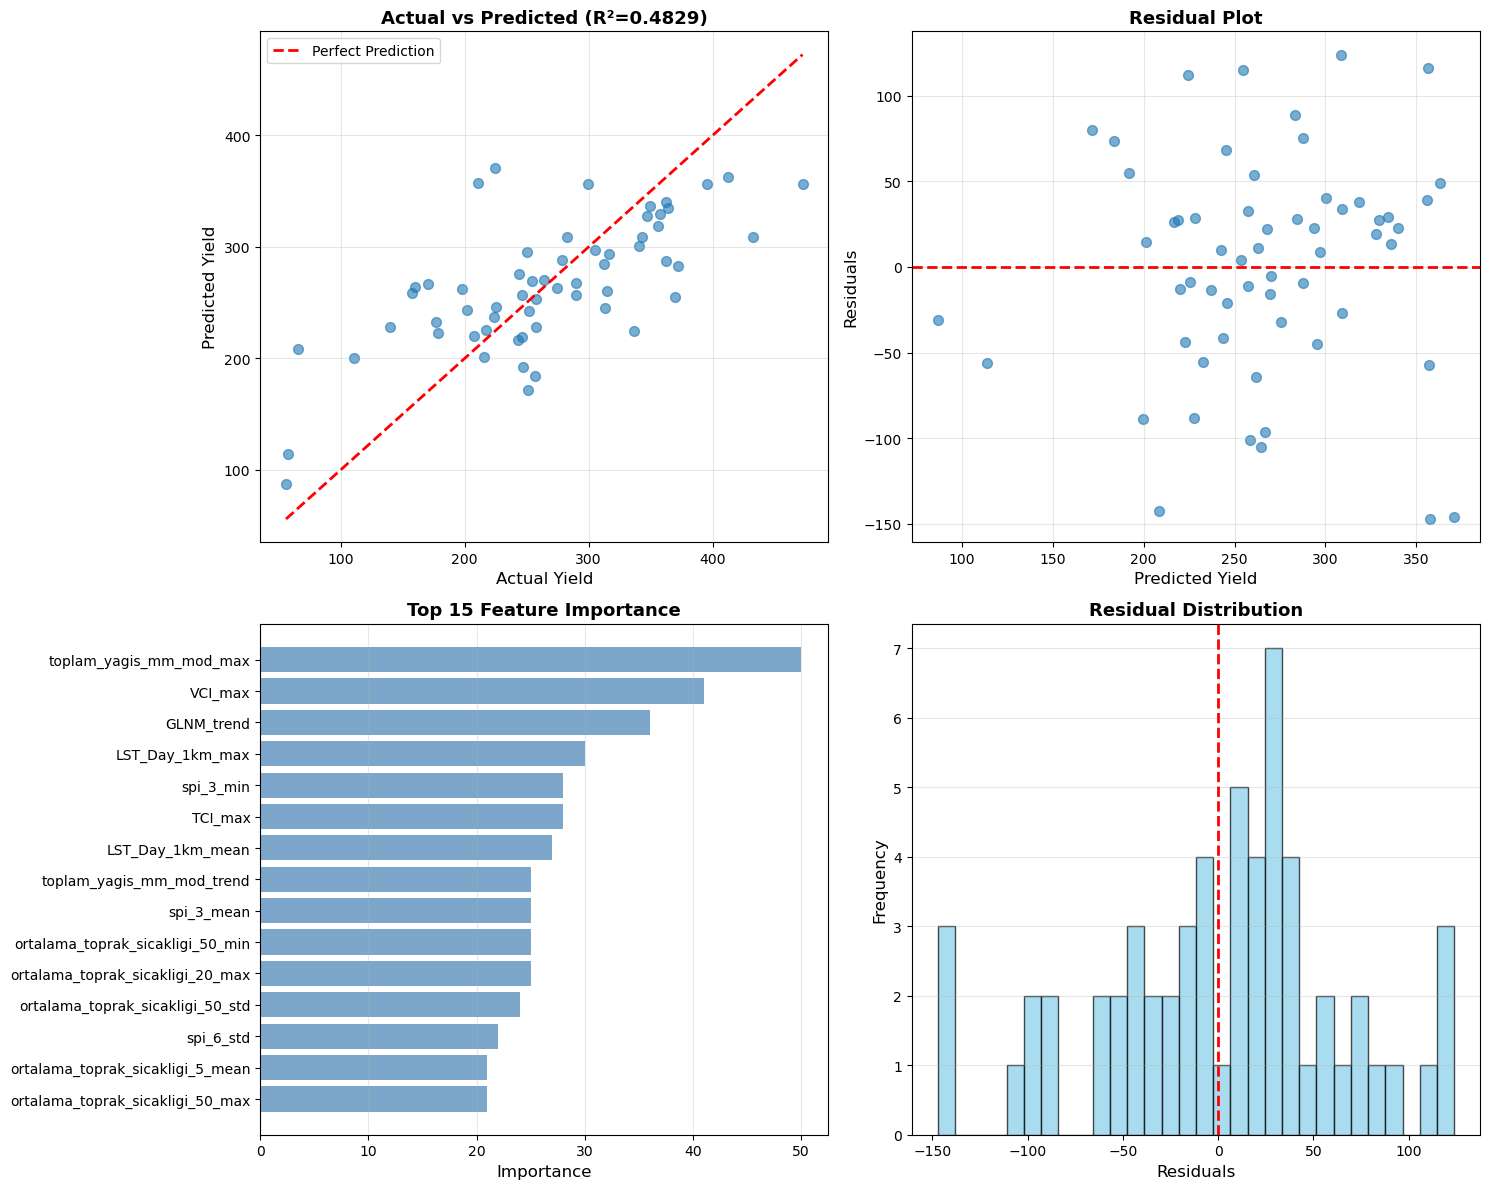


Final Results: RMSE=63.7234, R²=0.4829


In [29]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

X_summary_station_cleaned = X_summary_station.dropna(subset=["verim"])

X = X_summary_station_cleaned.drop(columns=["verim"]).copy()
y = X_summary_station_cleaned["verim"].copy()
X = X.fillna(X.mean())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = LGBMRegressor(
    n_estimators=200,           
    learning_rate=0.05,         
    max_depth=8,               
    num_leaves=31,             
    min_child_samples=20,      
    subsample=0.8,              
    colsample_bytree=0.8,       
    reg_alpha=0.1,              
    reg_lambda=0.1,            
    random_state=42,
    verbose=-1
)


model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    # early_stopping_rounds=20  
)


y_pred = model.predict(X_test)


rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("\n" + "="*60)
print("MODEL PERFORMANCE")
print("="*60)
print(f"RMSE:  {rmse:.4f}")
print(f"MAE:   {mae:.4f}")
print(f"R²:    {r2:.4f}")
print(f"MAPE:  {mape:.2f}%")
print("="*60)


results_station_summary = pd.DataFrame({
    "Gerçek Verim": y_test.values,
    "Tahmin Edilen Verim": y_pred,
    "Hata": y_test.values - y_pred,
    "Hata (%)": np.abs((y_test.values - y_pred) / y_test.values) * 100
}, index=y_test.index)

print("\nİlk 10 tahmin:")
print(results_station_summary.head(10))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*60)
print("TOP 15 MOST IMPORTANT FEATURES")
print("="*60)
for i, row in feature_importance.head(15).iterrows():
    print(f"{i+1:2d}. {row['Feature']:30s}: {row['Importance']:8.1f}")


fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted
axes[0, 0].scatter(y_test, y_pred, alpha=0.6, s=50)
axes[0, 0].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Yield', fontsize=12)
axes[0, 0].set_ylabel('Predicted Yield', fontsize=12)
axes[0, 0].set_title(f'Actual vs Predicted (R²={r2:.4f})', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals
residuals = y_test - y_pred
axes[0, 1].scatter(y_pred, residuals, alpha=0.6, s=50)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Yield', fontsize=12)
axes[0, 1].set_ylabel('Residuals', fontsize=12)
axes[0, 1].set_title('Residual Plot', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Feature Importance (Top 15)
top_features = feature_importance.head(15)
axes[1, 0].barh(range(len(top_features)), top_features['Importance'], color='steelblue', alpha=0.7)
axes[1, 0].set_yticks(range(len(top_features)))
axes[1, 0].set_yticklabels(top_features['Feature'])
axes[1, 0].set_xlabel('Importance', fontsize=12)
axes[1, 0].set_title('Top 15 Feature Importance', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')
axes[1, 0].invert_yaxis()

# 4. Error distribution
axes[1, 1].hist(residuals, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Residuals', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Residual Distribution', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('lightgbm_results.png', dpi=300, bbox_inches='tight')
plt.show()

# RMSE ve R² değerlerini döndür
print(f"\nFinal Results: RMSE={rmse:.4f}, R²={r2:.4f}")

In [34]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np

print("="*60)
print("LIGHTGBM WITH FEATURE GROUP COMPARISON")
print("="*60)

X_summary_station_cleaned = X_summary_station.dropna(subset=["verim"])
y = X_summary_station_cleaned["verim"].copy()

X_all = X_summary_station_cleaned.drop(columns=["verim"], errors='ignore').copy()
X_all = X_all.fillna(X_all.mean())

print(f"\nAvailable features: {X_all.columns.tolist()}")

# Özellik grupları tanımla
feature_groups = {
    'All Features': X_all.columns.tolist(),
    'Temperature Features': [col for col in X_all.columns if 'sicaklik' in col.lower() or 'temp' in col.lower() or 'lst' in col.lower()],
    'Drought Indices': [col for col in X_all.columns if any(idx in col.upper() for idx in ['GLI', 'GLNM', 'NDVI', 'NMDI', 'TCI', 'VCI', 'VHI', 'SPI', 'SPEI'])],
    'Soil Features': [col for col in X_all.columns if 'toprak' in col.lower() or 'soil' in col.lower()],
    'Climate Features': [col for col in X_all.columns if any(x in col.lower() for x in ['gdd', 'yagis', 'pet', 'dengesi', 'precipitation'])]
}

all_results = []

# Her özellik grubu için
for group_name, features in feature_groups.items():
    if len(features) == 0:
        continue
    
    print(f"\n{'='*60}")
    print(f"TRAINING MODEL: {group_name}")
    print(f"{'='*60}")
    print(f"Features: {features}")
    
    X_group = X_all[features].copy()
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_group, y, test_size=0.3, random_state=42
    )
    
    model = LGBMRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=8,
        num_leaves=31,
        random_state=42,
        verbose=-1
    )
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    print(f"\nPerformance:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE:  {mae:.2f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    all_results.append({
        'Group': group_name,
        'N Features': len(features),
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape
    })

print("\n" + "="*80)
print("COMPARISON")
print("="*80)
comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df.sort_values('RMSE')
print(comparison_df.to_string(index=False))

best_group = comparison_df.iloc[0]['Group']

LIGHTGBM WITH FEATURE GROUP COMPARISON

Available features: ['gdd_mean', 'gdd_std', 'gdd_min', 'gdd_max', 'gdd_trend', 'toplam_yagis_mm_mod_mean', 'toplam_yagis_mm_mod_std', 'toplam_yagis_mm_mod_min', 'toplam_yagis_mm_mod_max', 'toplam_yagis_mm_mod_trend', 'GLNM_mean', 'GLNM_std', 'GLNM_min', 'GLNM_max', 'GLNM_trend', 'TCI_mean', 'TCI_std', 'TCI_min', 'TCI_max', 'TCI_trend', 'VCI_mean', 'VCI_std', 'VCI_min', 'VCI_max', 'VCI_trend', 'ortalama_toprak_sicakligi_5_mean', 'ortalama_toprak_sicakligi_5_std', 'ortalama_toprak_sicakligi_5_min', 'ortalama_toprak_sicakligi_5_max', 'ortalama_toprak_sicakligi_5_trend', 'ortalama_toprak_sicakligi_10_mean', 'ortalama_toprak_sicakligi_10_std', 'ortalama_toprak_sicakligi_10_min', 'ortalama_toprak_sicakligi_10_max', 'ortalama_toprak_sicakligi_10_trend', 'ortalama_toprak_sicakligi_20_mean', 'ortalama_toprak_sicakligi_20_std', 'ortalama_toprak_sicakligi_20_min', 'ortalama_toprak_sicakligi_20_max', 'ortalama_toprak_sicakligi_20_trend', 'ortalama_toprak_sic

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

## LSTM+GRU+Attention

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

file_path = "all_merged_final.xlsx" 
xls = pd.ExcelFile(file_path)
df = xls.parse(xls.sheet_names[0])
df_filtered = df[df["verim"].notnull()].copy()
df_grouped = (
    df_filtered
    .groupby(['yil', 'istasyon_no', 'hafta'], as_index=False)
    .mean(numeric_only=True)
)
valid_cols = df_grouped.columns
exclude_cols = ['yil', 'istasyon_no', 'hafta', 'verim', 'uretim']
feature_cols = [col for col in valid_cols if col not in exclude_cols]

grouped = df_grouped.groupby(['yil', 'istasyon_no'])
X_list = []
y_list = []
years = []
stations = []

for (year, station), group in grouped:
    if group["hafta"].nunique() < 45:
        continue
    group_sorted = group.sort_values("hafta")
    
    group_padded = (
        group_sorted
        .set_index("hafta")
        .reindex(range(1, 53))
        .fillna(method="ffill")
        .fillna(method="bfill")
    )
    X_tensor = group_padded[feature_cols].values
    y_value = group_sorted["verim"].iloc[0]
    X_list.append(X_tensor)
    y_list.append(y_value)
    years.append(year)
    stations.append(station)

X_all = np.stack(X_list)
y_all = np.array(y_list)
years_all = np.array(years)
stations_all = np.array(stations)

# ===== FIX: Create index mappings =====
unique_years = np.unique(years_all)
unique_stations = np.unique(stations_all)

# Map actual values to 0-indexed values
year_to_idx = {year: idx for idx, year in enumerate(unique_years)}
station_to_idx = {station: idx for idx, station in enumerate(unique_stations)}

# Convert to indices
years_idx = np.array([year_to_idx[y] for y in years_all])
stations_idx = np.array([station_to_idx[s] for s in stations_all])

print(f"Year mapping: {dict(list(year_to_idx.items())[:5])}...")
print(f"Station mapping: {dict(list(station_to_idx.items())[:5])}...")
print(f"Unique years: {len(unique_years)}, Unique stations: {len(unique_stations)}")
# =====================================

# Min-Max Scaling
n_samples, n_weeks, n_features = X_all.shape
X_reshaped = X_all.reshape(-1, n_features)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X_all_scaled = X_scaled.reshape(n_samples, n_weeks, n_features)

# Train/Test Split - USE INDEX VERSIONS
X_train, X_test, y_train, y_test, years_train_idx, years_test_idx, stations_train_idx, stations_test_idx = train_test_split(
    X_all_scaled, y_all, years_idx, stations_idx, test_size=0.2, random_state=42
)

print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Features: {len(feature_cols)}")

# =============================================================================
# PYTORCH DATASET
# =============================================================================
class WheatYieldDataset(Dataset):
    """Dataset for wheat yield prediction with metadata"""
    def __init__(self, X, y, years_idx, stations_idx):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        self.years = torch.LongTensor(years_idx)  # Already indexed!
        self.stations = torch.LongTensor(stations_idx)  # Already indexed!
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return {
            'sequence': self.X[idx],
            'year': self.years[idx],
            'station': self.stations[idx],
            'yield': self.y[idx]
        }

# Create datasets
train_dataset = WheatYieldDataset(X_train, y_train, years_train_idx, stations_train_idx)
test_dataset = WheatYieldDataset(X_test, y_test, years_test_idx, stations_test_idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# =============================================================================
# WEEK-BIASED ATTENTION MECHANISM
# =============================================================================
class WeekBiasedAttention(nn.Module):
    """
    Attention mechanism with bias toward critical phenological weeks (18-26)
    Based on: Lobell & Field (2007) - heading, flowering, and grain filling stages
    """
    def __init__(self, hidden_size, critical_weeks=(18, 26)):
        super().__init__()
        self.attention = nn.Linear(hidden_size, 1)
        self.critical_weeks = critical_weeks
        
        # Create bias vector (52 weeks)
        self.register_buffer('week_bias', self._create_week_bias())
    
    def _create_week_bias(self):
        """Create bias vector emphasizing weeks 18-26"""
        bias = torch.zeros(52)
        start, end = self.critical_weeks
        bias[start-1:end] = 1.0  # Weeks 18-26 (index 17:26)
        return bias
    
    def forward(self, lstm_output):
        """
        Args:
            lstm_output: (batch, 52, hidden_size)
        Returns:
            context: (batch, hidden_size)
            attention_weights: (batch, 52)
        """
        # Compute attention scores
        attn_scores = self.attention(lstm_output).squeeze(-1)  # (batch, 52)
        
        # Add phenological bias
        attn_scores = attn_scores + self.week_bias  # (batch, 52)
        
        # Softmax to get weights
        attn_weights = torch.softmax(attn_scores, dim=1)  # (batch, 52)
        
        # Weighted sum (context vector)
        context = torch.sum(attn_weights.unsqueeze(-1) * lstm_output, dim=1)  # (batch, hidden_size)
        
        return context, attn_weights

# =============================================================================
# LSTM-GRU HYBRID MODEL
# =============================================================================
class LSTMGRUYieldPredictor(nn.Module):
    """
    Hybrid LSTM-GRU model with week-biased attention for wheat yield prediction
    """
    def __init__(self, input_size, hidden_size=128, n_years=20, n_stations=50, 
                 embedding_dim=16, dropout=0.3):
        super().__init__()
        
        # Embeddings for year and district
        self.year_embedding = nn.Embedding(n_years, embedding_dim)
        self.station_embedding = nn.Embedding(n_stations, embedding_dim)
        
        # LSTM layers (parallel processing)
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, 
                             dropout=dropout, bidirectional=False)
        self.lstm2 = nn.LSTM(input_size, hidden_size, batch_first=True, 
                             dropout=dropout, bidirectional=False)
        
        # Bidirectional GRU
        self.gru = nn.GRU(hidden_size * 2, hidden_size, batch_first=True, 
                          dropout=dropout, bidirectional=True)
        
        # Week-biased attention mechanism
        self.attention = WeekBiasedAttention(hidden_size * 2, critical_weeks=(18, 26))
        
        # Fully connected layers
        fc_input_size = hidden_size * 2 + embedding_dim * 2
        self.fc1 = nn.Linear(fc_input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(dropout)
        
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(dropout)
        
        self.output = nn.Linear(64, 1)
        
        self.relu = nn.ReLU()
    
    def forward(self, sequence, year, station):
        """
        Args:
            sequence: (batch, 52, input_size)
            year: (batch,) - INDEXED year (0, 1, 2, ...)
            station: (batch,) - INDEXED station (0, 1, 2, ...)
        """
        batch_size = sequence.size(0)
        
        # Embeddings
        year_emb = self.year_embedding(year)
        station_emb = self.station_embedding(station)
        
        # Parallel LSTM processing
        lstm1_out, _ = self.lstm1(sequence)
        lstm2_out, _ = self.lstm2(sequence)
        
        # Concatenate LSTM outputs
        lstm_concat = torch.cat([lstm1_out, lstm2_out], dim=-1)
        
        # Bidirectional GRU
        gru_out, _ = self.gru(lstm_concat)
        
        # Week-biased attention
        context, attn_weights = self.attention(gru_out)
        
        # Concatenate with embeddings
        combined = torch.cat([context, year_emb, station_emb], dim=-1)
        
        # Dense layers
        x = self.fc1(combined)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        yield_pred = self.output(x)
        
        return yield_pred, attn_weights

# =============================================================================
# TRAINING FUNCTION
# =============================================================================
def train_model(model, train_loader, test_loader, epochs=100, lr=0.001, 
                patience=10, device='cuda'):
    """Train LSTM-GRU model with early stopping and gradient clipping"""
    
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                                  betas=(0.9, 0.999), weight_decay=1e-5)
    

    torch.save(model.state_dict(), 'best_model.pth')
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        nan_detected = False  
        
        for batch in train_loader:
            sequence = batch['sequence'].to(device)
            year = batch['year'].to(device)
            station = batch['station'].to(device)
            target = batch['yield'].to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            pred, _ = model(sequence, year, station)
            
            if torch.isnan(pred).any():
                print(f"NaN detected in predictions at epoch {epoch+1}")
                nan_detected = True
                break
            
            loss = criterion(pred, target)
            
            if torch.isnan(loss):
                print(f"NaN detected in loss at epoch {epoch+1}")
                nan_detected = True
                break
            
            loss.backward()
            
            # Gradient clipping (prevent explosion)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
        
        if nan_detected:
            print("Training stopped due to NaN. Loading best model...")
            break
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                sequence = batch['sequence'].to(device)
                year = batch['year'].to(device)
                station = batch['station'].to(device)
                target = batch['yield'].to(device).unsqueeze(1)
                
                pred, _ = model(sequence, year, station)
                

                if torch.isnan(pred).any():
                    break
                
                loss = criterion(pred, target)
                val_loss += loss.item()
        
        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Load best model
    try:
        model.load_state_dict(torch.load('best_model.pth'))
        print(f"\nLoaded best model with Val Loss: {best_val_loss:.4f}")
    except FileNotFoundError:
        print("Warning: best_model.pth not found. Using current model state.")
        torch.save(model.state_dict(), 'best_model.pth')
    
    return model, train_losses, val_losses
    
# =============================================================================
# EVALUATION FUNCTION
# =============================================================================
def evaluate_model(model, test_loader, device='cuda'):
    """Evaluate model and compute metrics"""
    model.eval()
    predictions = []
    actuals = []
    all_attention_weights = []
    
    with torch.no_grad():
        for batch in test_loader:
            sequence = batch['sequence'].to(device)
            year = batch['year'].to(device)
            station = batch['station'].to(device)
            target = batch['yield'].to(device)
            
            pred, attn_weights = model(sequence, year, station)
            
            pred_numpy = pred.squeeze().cpu().numpy()
            target_numpy = target.cpu().numpy()
            
            if np.isnan(pred_numpy).any():
                print(f"Skipping batch with NaN predictions")
                continue
            
            predictions.extend(pred_numpy)
            actuals.extend(target_numpy)
            all_attention_weights.append(attn_weights.cpu().numpy())
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    if len(predictions) == 0 or np.isnan(predictions).any():
        return None, None, None, None
    
    # Compute metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    
    print("\n" + "="*60)
    print("MODEL EVALUATION RESULTS")
    print("="*60)
    print(f"RMSE:  {rmse:.4f}")
    print(f"MAE:   {mae:.4f}")
    print(f"R²:    {r2:.4f}")
    print(f"MAPE:  {mape:.2f}%")
    print("="*60 + "\n")
    
    return predictions, actuals, all_attention_weights, {'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape}
# =============================================================================
# VISUALIZATION FUNCTIONS
# =============================================================================
def plot_training_history(train_losses, val_losses):
    """Plot training and validation loss"""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.title('Training History', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300)
    plt.show()

def plot_predictions(actuals, predictions):
    """Plot actual vs predicted yields"""
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, predictions, alpha=0.6, s=50)
    plt.plot([actuals.min(), actuals.max()], 
             [actuals.min(), actuals.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
    plt.xlabel('Actual Yield (kg/da)', fontsize=12)
    plt.ylabel('Predicted Yield (kg/da)', fontsize=12)
    plt.title('Actual vs Predicted Wheat Yield', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('predictions_scatter.png', dpi=300)
    plt.show()

def plot_attention_weights(attention_weights):
    """Plot average attention weights across all samples"""
    avg_attention = np.mean(np.concatenate(attention_weights, axis=0), axis=0)
    
    plt.figure(figsize=(14, 6))
    weeks = np.arange(1, 53)
    plt.bar(weeks, avg_attention, color='steelblue', alpha=0.7)
    
    # Highlight critical weeks (18-26)
    plt.axvspan(18, 26, color='green', alpha=0.2, label='Critical Weeks (18-26)')
    
    plt.xlabel('Week', fontsize=12)
    plt.ylabel('Average Attention Weight', fontsize=12)
    plt.title('Week-Biased Attention Weights (Averaged Across All Samples)', 
              fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('attention_weights.png', dpi=300)
    plt.show()
    
    # Print top attended weeks
    top_weeks = np.argsort(avg_attention)[-10:][::-1] + 1
    print("\nTop 10 Most Attended Weeks:")
    for i, week in enumerate(top_weeks, 1):
        print(f"  {i}. Week {week}: {avg_attention[week-1]:.4f}")

# =============================================================================
# MAIN EXECUTION
# =============================================================================
if __name__ == "__main__":
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}\n")
    
    n_years = len(unique_years)
    n_stations = len(unique_stations)
    
    print(f"Number of unique years: {n_years}")
    print(f"Number of unique stations: {n_stations}")
    print(f"Input features: {n_features}\n")
    
    # Initialize model
    model = LSTMGRUYieldPredictor(
        input_size=n_features,
        hidden_size=128,
        n_years=n_years,
        n_stations=n_stations,
        embedding_dim=16,
        dropout=0.3
    )
    
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, (nn.LSTM, nn.GRU)):
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(param.data)
                elif 'bias' in name:
                    nn.init.zeros_(param.data)
    
    model.apply(init_weights)
    
    print("Model Architecture:")
    print(model)
    print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}\n")
    
    # Train model with LOWER learning rate
    print("="*60)
    print("TRAINING LSTM-GRU MODEL WITH WEEK-BIASED ATTENTION")
    print("="*60 + "\n")
    
    model, train_losses, val_losses = train_model(
        model, train_loader, test_loader,
        epochs=100,
        lr=0.0005,  
        patience=15,
        device=device
    )
    
    # Evaluate model
    predictions, actuals, attention_weights, metrics = evaluate_model(
        model, test_loader, device
    )
    
    # Visualizations
    plot_training_history(train_losses, val_losses)
    plot_predictions(actuals, predictions)
    plot_attention_weights(attention_weights)